In [183]:
import tifffile
import matplotlib.pyplot as plt
import matplotlib as mpl
img = tifffile.imread("../testing/easy_test_data.tif", key = 0)
import sys
sys.path.append("../testing/video_sims")
from subpix_signals import subpix_signals
import trackpy as tp
from skimage.feature.blob import *
from skimage.feature.blob import _prune_blobs, _supported_float_type, _format_exclude_border
import pandas as pd
from matplotlib import animation as ani

In [140]:
def blob_log(image, min_sigma=1, max_sigma=50, num_sigma=10, threshold=.2,
             overlap=.5, log_scale=False, *, threshold_rel=None,
             exclude_border=False):
    global gl_images
    image = img_as_float(image)
    float_dtype = _supported_float_type(image.dtype)
    image = image.astype(float_dtype, copy=False)

    # if both min and max sigma are scalar, function returns only one sigma
    scalar_sigma = (
        True if np.isscalar(max_sigma) and np.isscalar(min_sigma) else False
    )

    # Gaussian filter requires that sequence-type sigmas have same
    # dimensionality as image. This broadcasts scalar kernels
    if np.isscalar(max_sigma):
        max_sigma = np.full(image.ndim, max_sigma, dtype=float_dtype)
    if np.isscalar(min_sigma):
        min_sigma = np.full(image.ndim, min_sigma, dtype=float_dtype)

    # Convert sequence types to array
    min_sigma = np.asarray(min_sigma, dtype=float_dtype)
    max_sigma = np.asarray(max_sigma, dtype=float_dtype)

    if log_scale:
        start = np.log10(min_sigma)
        stop = np.log10(max_sigma)
        sigma_list = np.logspace(start, stop, num_sigma)
    else:
        sigma_list = np.linspace(min_sigma, max_sigma, num_sigma)

    # computing gaussian laplace
    # average s**2 provides scale invariance
    gl_images = [-ndi.gaussian_laplace(image, s) * np.mean(s) ** 2
                 for s in sigma_list]

    image_cube = np.stack(gl_images, axis=-1)

    exclude_border = _format_exclude_border(image.ndim, exclude_border)
    local_maxima = peak_local_max(
        image_cube,
        threshold_abs=threshold,
        threshold_rel=threshold_rel,
        exclude_border=exclude_border,
        footprint=np.ones((3,) * (image.ndim + 1)),
    )

    # Catch no peaks
    if local_maxima.size == 0:
        return np.empty((0, image.ndim + (1 if scalar_sigma else image.ndim)))

    # Convert local_maxima to float64
    lm = local_maxima.astype(float_dtype)

    # translate final column of lm, which contains the index of the
    # sigma that produced the maximum intensity value, into the sigma
    sigmas_of_peaks = sigma_list[local_maxima[:, -1]]

    if scalar_sigma:
        # select one sigma column, keeping dimension
        sigmas_of_peaks = sigmas_of_peaks[:, 0:1]

    # Remove sigma index and replace with sigmas
    lm = np.hstack([lm[:, :-1], sigmas_of_peaks])

    sigma_dim = sigmas_of_peaks.shape[1]

    # return _prune_blobs(lm, overlap, sigma_dim=sigma_dim)

In [ ]:
from skimage.feature.blob import blob_log

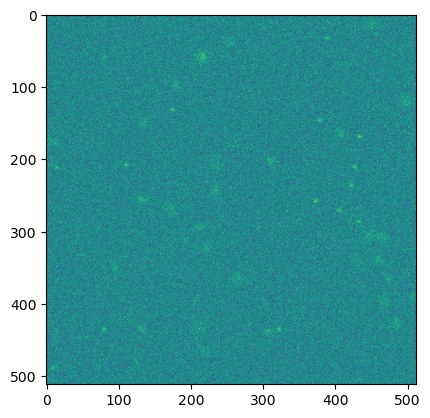

In [159]:
shape = np.array([512, 512])
n_parts = 15
bg = np.random.normal(size = shape).astype("float32")*50 + 1000
pic = bg.copy()
for i in range(3):
    parts = np.random.uniform(size = (n_parts, 2))
    parts = parts*(shape - 1).reshape(-1, 2)
    intensities = 3000 + i*3000
    subpix_signals(parts, sigmas = 2 + 2*i, picture = pic, intensities = intensities)
plt.imshow(pic)

In [171]:
blob_log(pic.astype("float32"), min_sigma = 1, max_sigma = 8, num_sigma = 30)
gl_images = np.stack(gl_images)

In [193]:
artists = [plt.imshow(gl_images[i], vmin = gl_images.min(), vmax = gl_images.max(), animated = True) for i in range(len(gl_images))]
anim = ani.ArtistAnimation(plt.gcf(), artists = artists)
plt.show()

<IPython.core.display.Javascript object>

c:\Users\andre\anaconda3\envs\tracking-script\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


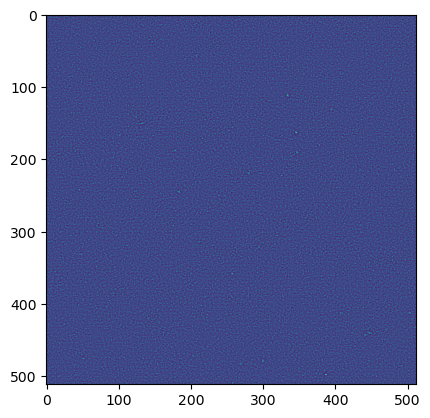

In [108]:
plt.imshow(gl_images[0][100:200, 300:400], vmin = gl_images.min(), vmax = gl_images.max())

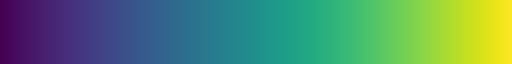

In [2]:
mpl.colormaps["viridis"]